## Module 3 - Arbres de décisions

### Étape 1

Les arbres de décision sont des modèles de prédiction utilisés pour la classification et la régression. Leur structure arborescente est composée de nœuds de décision, de branches et de feuilles. Chaque nœud interne représente un test sur une variable, chaque branche représente le résultat du test, et chaque feuille représente une étiquette de classe (dans le cas de la classification) ou une valeur (dans le cas de la régression). L'objectif des arbres de décision est de créer un modèle qui prédit la valeur de la variable cible en apprenant des règles de décision simples déduites des données caractéristiques. Ils sont appréciés pour leur simplicité et leur capacité à gérer des données à la fois numériques et catégorielles. Cependant, ils peuvent être sujets à un surajustement, d'où la nécessité de techniques comme l'élagage pour améliorer la généralisation.

### Étape 2

In [40]:
import pandas as pd

# Chargement du fichier DonneesAchat.xlsx
df = pd.read_excel('DonneesAchat.xlsx').iloc[:, 1:]

# Affichage des premières lignes pour vérifier le chargement
df.head()


/Users/andresmorales/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Age,Sexe,Etat_civil,Revenu,Acheter
0,Adulte,Homme,Marié,Moyen,Non
1,Jeune,Homme,Célibataire,Faible,Non
2,Agé,Homme,Marié,Élevé,Oui
3,Jeune,Femme,Célibataire,Moyen,Non
4,Adulte,Homme,Célibataire,Moyen,Non


In [41]:

# Identification des variables
variables = df.columns
print("Les variables sont :", variables)

Les variables sont : Index(['Age', 'Sexe', 'Etat_civil', 'Revenu', 'Acheter'], dtype='object')


### Étape 3

Calcul de l'entropie, gain d'information et indice Gini :

In [85]:
import numpy as np

# Fonction pour calculer l'entropie
def calculer_entropie(colonne):
    elements, counts = np.unique(colonne, return_counts=True)
    entropie = -np.sum([(counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropie

# Fonction pour calculer l'entropie pondérée

def calculer_entropie_pondérée(df, attribut, cible):
    valeurs_attribut, counts_attribut = np.unique(df[attribut], return_counts=True)
    entropie_pondérée = np.sum([(counts_attribut[i]/np.sum(counts_attribut)) * calculer_entropie(df.where(df[attribut] 
    == valeurs_attribut[i]).dropna()[cible]) for i in range(len(valeurs_attribut))])
    return entropie_pondérée

# Fonction pour calculer le gain d'information
def calculer_gain_information(df, attribut, cible):
    return calculer_entropie(df[cible]) - calculer_entropie_pondérée(df, attribut, cible)

# Fonction pour calculer l'indice Gini
def calculer_indice_gini(colonne):
    elements, counts = np.unique(colonne, return_counts=True)
    gini = 1 - np.sum([(counts[i]/np.sum(counts))**2 for i in range(len(elements))])
    return gini

# Fonction pour calculer le ratio de gain
def calculer_ratio_gain(df, attribut, cible):
    return calculer_gain_information(df, attribut, cible) / calculer_entropie(df[attribut])

# Variables et calculs
variables = ['Age', 'Sexe', 'Etat_civil', 'Revenu']
cible = 'Acheter'

# Calculs de la entropie pour la cible, entropie pondérée pour les variables, gain d'information et indice Gini
entropie_cible = calculer_entropie(df[cible])
entropies = [calculer_entropie(df[variable]) for variable in variables]
entropies_pondérées = [calculer_entropie_pondérée(df, variable, cible) for variable in variables]
gains_information = [calculer_gain_information(df, variable, cible) for variable in variables]
indices_gini = [calculer_indice_gini(df[variable]) for variable in variables]
rapport_gain = [calculer_ratio_gain(df, variable, cible) for variable in variables]

# Affichage des résultats   
df_resultats = pd.DataFrame({'Variable': variables, 'Entropie': entropies, 'Entropie pondérée': entropies_pondérées, 
                             'Gain information': gains_information, 'Rapport de gain': rapport_gain, 'Indice Gini': indices_gini})
print("Résultats :")
print("L'entropie de la cible 'jouer' est :", entropie_cible)
print("L'indice gini de la cible 'jouer' est :", calculer_indice_gini(df[cible]))

df_resultats





Résultats :
L'entropie de la cible 'jouer' est : 1.0
L'indice gini de la cible 'jouer' est : 0.5


,Variable,Entropie,Entropie pondérée,Gain information,Rapport de gain,Indice Gini
0,Age,1.492614,0.492614,0.507386,0.339931,0.622449
1,Sexe,1.000000,0.985228,0.014772,0.014772,0.500000
2,Etat_civil,0.985228,0.938946,0.061054,0.061969,0.489796
3,Revenu,1.835238,0.578562,0.421438,0.229637,0.704082


### Étape 4

Construction d'un arbre de décision en utilisant l'algorithme ID3 :

In [69]:
# Construisez, pas à pas, un arbre decision en utilisant l'algorithme ID3

# Fonction pour construire un arbre de décision

def construire_arbre_decision(df, cible, attributs):
    # Cas d'arrêt : si tous les exemples ont la même valeur pour la cible
    if len(np.unique(df[cible])) <= 1:
        return np.unique(df[cible])[0]
    
    # Cas d'arrêt : si la liste des attributs est vide
    elif len(attributs) == 0:
        return np.unique(df[cible])[np.argmax(np.unique(df[cible], return_counts=True)[1])]
    
    # Cas général
    else:
        # Sélection de l'attribut qui maximise le gain d'information
        gain_information = [calculer_gain_information(df, attribut, cible) for attribut in attributs]
        attribut_max = attributs[np.argmax(gain_information)]
        
        # Création de l'arbre
        arbre = {attribut_max: {}}
        attributs = [attribut for attribut in attributs if attribut != attribut_max]
        
        for valeur in np.unique(df[attribut_max]):
            sous_ensemble = df.where(df[attribut_max] == valeur).dropna()
            arbre[attribut_max][valeur] = construire_arbre_decision(sous_ensemble, cible, attributs)
        
        return arbre
    
# Variables et calculs
variables = ['Age', 'Sexe', 'Etat_civil', 'Revenu']
cible = 'Acheter'

# Construction de l'arbre de décision
arbre = construire_arbre_decision(df, cible, variables)

# Affichage de l'arbre
import pprint
pprint.pprint(arbre)



{'Age': {'Adulte': {'Revenu': {'Faible': 'Non',
                               'Moyen': {'Sexe': {'Femme': 'Oui',
                                                  'Homme': 'Non'}},
                               'Élevé': 'Oui'}},
         'Agé': 'Oui',
         'Jeune': 'Non'}}


In [73]:
# affichage de l'arbre

# Fonction pour afficher l'arbre de décision
def afficher_arbre(arbre, espace=' '):
    for cle in arbre:
        if type(arbre[cle]) is dict:
            print(espace + cle)
            afficher_arbre(arbre[cle], espace + ' ')
        else:
            print(espace + cle + ' : ' + arbre[cle])

# Affichage de l'arbre
afficher_arbre(arbre)

 Age
  Adulte
   Revenu
    Faible : Non
    Moyen
     Sexe
      Femme : Oui
      Homme : Non
    Élevé : Oui
  Agé : Oui
  Jeune : Non


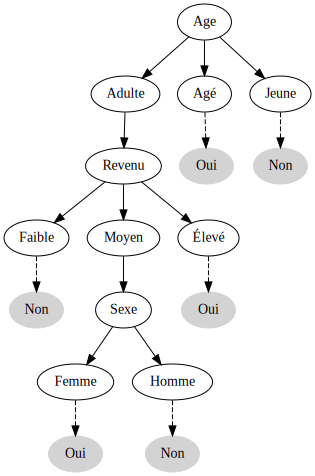

In [74]:
from graphviz import Digraph

# Define the decision tree structure
decision_tree_graph_id3 = {
    'Age': {
        'Adulte': {
            'Revenu': {
                'Faible': 'Non',
                'Moyen': {
                    'Sexe': {
                        'Femme': 'Oui',
                        'Homme': 'Non'
                    }
                },
                'Élevé': 'Oui'
            }
        },
        'Agé': 'Oui',
        'Jeune': 'Non'
    }
}

# Initialize the graph
dot = Digraph()

# Function to add nodes and edges to the graph in Graphviz format
def add_edges_graphviz(graph, tree, parent=None):
    for key, value in tree.items():
        if parent is None:
            node_label = key
            graph.node(node_label, key)
        else:
            node_label = parent + "->" + key
            graph.node(node_label, key)
            graph.edge(parent, node_label)
        
        if isinstance(value, dict):
            add_edges_graphviz(graph, value, node_label)
        else:
            leaf_label = node_label + "->" + value
            graph.node(leaf_label, value, shape='ellipse', style='filled', color='lightgrey')
            graph.edge(node_label, leaf_label, style='dashed')

# Add nodes and edges to the graph
decision_tree_graph_id3 = add_edges_graphviz(dot, decision_tree_graph_id3)

# Display the graph

dot.render('arbre_decision', format='png', cleanup=True)
dot


In [80]:
# En utilisant cet arbre de decision, predize la réposne des trois personnes suivantes:
# Personne 1: Il s'agit d'un homme marié dont le revenu est moyen.
# Personne 2: Il s'agit d'un homme célibataure dont le revenu est moyen.
# Personne 3: Il s'agit d'un homme dont le revenu est moyen.

# Fonction pour prédire la réponse

def predire_reponse(instance, arbre):
    attribut = list(arbre.keys())[0]
    sous_arbre = arbre[attribut]
    valeur_attribut = instance[attribut]
    
    if valeur_attribut in sous_arbre.keys():
        resultat = sous_arbre[valeur_attribut]
        
        if isinstance(resultat, dict):
            return predire_reponse(instance, resultat)
        else:
            return resultat
        
    else:
        return 'Inconnu'
    
# Personnes à prédire
personnes = [
    {'Age': 'Adulte', 'Sexe': 'Homme', 'Etat_civil': 'Marié', 'Revenu': 'Moyen'},
    {'Age': 'Adulte', 'Sexe': 'Homme', 'Etat_civil': 'Célibataire', 'Revenu': 'Moyen'},
    {'Age': 'Adulte', 'Sexe': 'Homme', 'Etat_civil': '', 'Revenu': 'Moyen'}
]

# Prédictions
for i, personne in enumerate(personnes):
    prediction = predire_reponse(personne, arbre)
    print(f'Personne {i+1}: {prediction}')


Personne 1: Non
Personne 2: Non
Personne 3: Non


L'arbre de décision suggère que la variable principale pour prédire si une personne achète ou non est l'âge. Si la personne est jeune, peu importe son sexe, son état civil ou ses revenus, la prédiction est qu'elle n'achètera pas. De même, pour les personnes âgées, on prédit qu'elles achèteront indépendamment de leur condition.

Par ailleurs, si l'on suppose que la personne est adulte, les trois cas posés se réduisent au cas où l'on souhaite prédire pour un homme aux revenus moyens, dont on prédit qu'il n'achètera pas. La variable état civil est donc sans importance pour la prédiction selon cet algorithme.


In [75]:
# Si on teste avec une femme adulte mariée et dont le revenu est moyen
personne = {'Age': 'Adulte', 'Sexe': 'Femme', 'Etat_civil': 'Marié', 'Revenu': 'Moyen'}

prediction = predire_reponse(personne, arbre)

print(f'Femme 1: {prediction}')

Femme 1: Oui


### Étape 5

La variable "État Civil" a l'indice Gini le plus faible (0.4898). Par conséquent, "État Civil" devrait être choisie comme variable racine de l'arbre de décision.

In [77]:
# En utilisan l'algorithme CART, construisez un arbre de décision

# Fonction pour construire un arbre de décision avec l'algorithme CART

def construire_arbre_decision_CART(df, cible, attributs):
    # Cas d'arrêt: si tous les exemples appartiennent à la même classe
    if len(np.unique(df[cible])) <= 1:
        return np.unique(df[cible])[0]
    # Cas d'arrêt: si la liste des attributs est vide
    elif len(attributs) == 0:
        return np.unique(df[cible])[np.argmax(np.unique(df[cible], return_counts=True)[1])]
    # Cas général
    else:
        # Sélectionner l'attribut qui donne le meilleur indice Gini
        indices_gini = {attribut: calculer_indice_gini(df[attribut]) for attribut in attributs}
        attribut_min_indice_gini = min(indices_gini, key=indices_gini.get)
        arbre = {attribut_min_indice_gini: {}}
        attributs_restants = [attribut for attribut in attributs if attribut != attribut_min_indice_gini]
        for valeur_attribut in np.unique(df[attribut_min_indice_gini]):
            sous_ensemble = df.where(df[attribut_min_indice_gini] == valeur_attribut).dropna()
            arbre[attribut_min_indice_gini][valeur_attribut] = construire_arbre_decision_CART(sous_ensemble, cible, attributs_restants)
        return arbre
    
# Construire l'arbre de décision avec l'algorithme CART
arbre_CART = construire_arbre_decision_CART(df, cible, variables)

# Affichage de l'arbre de décision
afficher_arbre(arbre_CART)


 Etat_civil
  Célibataire
   Sexe
    Femme
     Age
      Adulte : Oui
      Agé : Oui
      Jeune : Non
    Homme
     Revenu
      Faible
       Age
        Adulte : Non
        Agé : Oui
        Jeune : Non
      Moyen : Non
  Marié
   Age
    Adulte
     Sexe
      Femme
       Revenu
        Faible : Non
        Moyen : Oui
      Homme
       Revenu
        Moyen : Non
        Élevé : Oui
    Agé : Oui


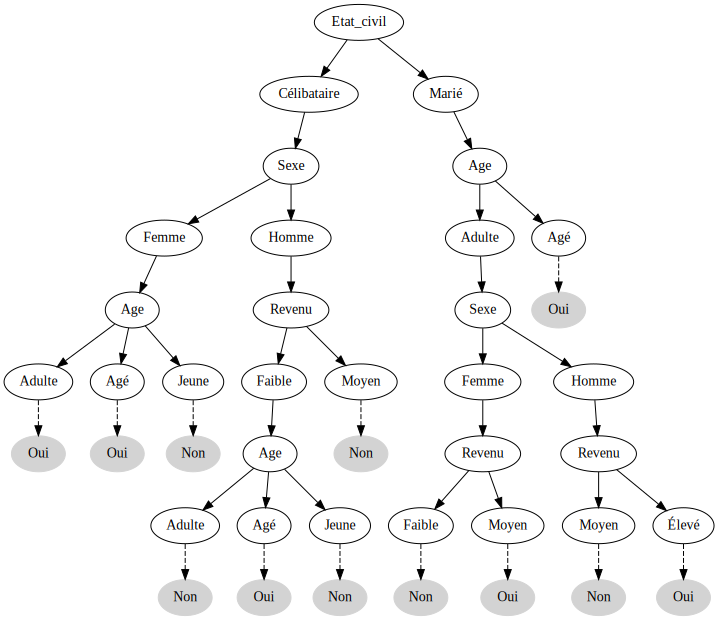

In [78]:

# Define the decision tree structure
decision_tree_graph_cart = {
    'Etat_civil': {
        'Célibataire': {
            'Sexe': {
                'Femme': {
                    'Age': {
                        'Adulte': 'Oui',
                        'Agé': 'Oui',
                        'Jeune': 'Non'
                    }
                },
                'Homme': {
                    'Revenu': {
                        'Faible': {
                            'Age': {
                                'Adulte': 'Non',
                                'Agé': 'Oui',
                                'Jeune': 'Non'
                            }
                        },
                        'Moyen': 'Non'
                    }
                }
            }
        },
        'Marié': {
            'Age': {
                'Adulte': {
                    'Sexe': {
                        'Femme': {
                            'Revenu': {
                                'Faible': 'Non',
                                'Moyen': 'Oui'
                            }
                        },
                        'Homme': {
                            'Revenu': {
                                'Moyen': 'Non',
                                'Élevé': 'Oui'
                            }
                        }
                    }
                },
                'Agé': 'Oui'
            }
        }
    }
}


# Initialize the graph
dot = Digraph()

# Function to add nodes and edges to the graph in Graphviz format
def add_edges_graphviz(graph, tree, parent=None):
    for key, value in tree.items():
        if parent is None:
            node_label = key
            graph.node(node_label, key)
        else:
            node_label = parent + "->" + key
            graph.node(node_label, key)
            graph.edge(parent, node_label)
        
        if isinstance(value, dict):
            add_edges_graphviz(graph, value, node_label)
        else:
            leaf_label = node_label + "->" + value
            graph.node(leaf_label, value, shape='ellipse', style='filled', color='lightgrey')
            graph.edge(node_label, leaf_label, style='dashed')

# Add nodes and edges to the graph
decision_tree_graph_cart = add_edges_graphviz(dot, decision_tree_graph_cart)

# Display the graph

dot.render('arbre_decision', format='png', cleanup=True)
dot

In [91]:
# Prédire la réponse des trois personnes.

for i, personne in enumerate(personnes):
    prediction = predire_reponse(personne, arbre_CART)
    print(f'Personne {i+1}: {prediction}')

# Si on teste avec un home adulte marié et dont le revenu est élevé
personne4  = {'Age': 'Adulte', 'Sexe': 'Homme', 'Etat_civil': 'Marié', 'Revenu': 'Élevé'}

prediction = predire_reponse(personne4, arbre_CART)

print(f'Personne 4: {prediction}')


Personne 1: Non
Personne 2: Non
Personne 3: Inconnu
Personne 4: Oui


Dans cet algorithme, l'état civil est le facteur le plus important pour la classification. La Personne 1 se situe sur le côté droit de l'arbre (branche "marié"), où l'âge est le deuxième facteur le plus important. Si cette Personne 1 est âgée, il est prédit qu'elle achètera, indépendamment du genre. En revanche, si l'homme est adulte et a un revenu moyen, il est prédit qu'il n'achètera pas.

Pour la Personne 2, elle se situe sur le côté gauche (célibataire) et il est prédit qu'elle n'achètera pas car elle a des revenus moyens.
Pour la Personne 3, l'analyse regroupe les deux premiers cas. Dans les deux cas (marié ou célibataire), il est prédit que cette personne n'achètera pas, sauf si c'est un homme âgé et marié, auquel cas il est prédit qu'il achètera.


### Étape 6

Les deux méthodes de classification, ID3 et CART, utilisent des critères différents pour déterminer la variable principale de la prédiction. Dans l'algorithme ID3, l'âge est la variable principale : si une personne est jeune, elle n'achètera pas, et si elle est âgée, elle achètera, indépendamment d'autres facteurs comme le sexe, l'état civil ou les revenus. En revanche, pour les hommes adultes avec un revenu moyen, l'algorithme prédit qu'ils n'achèteront pas, sans tenir compte de leur état civil.

Dans l'algorithme CART, l'état civil est le critère principal : une personne mariée âgée achètera, tandis qu'un homme adulte avec un revenu moyen n'achètera pas. Pour les célibataires avec des revenus moyens, la prédiction est qu'ils n'achèteront pas. Ainsi, CART utilise d'abord l'état civil pour la classification, puis l'âge et les revenus pour affiner les prédictions. Les deux méthodes fournissent des perspectives différentes sur les variables déterminantes et leur importance relative pour la décision d'achat.